In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# パッケージのインストール&インポート
!pip install rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio

import json
import os
import glob

import time
from datetime import datetime
from dateutil.parser import parse

In [ ]:
!pip install folium

import folium

関心域のポリゴン作成およびその位置情報を取得するWebアプリを作成しました．以下のサイトより，関心粋の選択（左の作成チールより四角を選択），ポリゴンを作成。その後”Show feature”をクリックしポリゴン情報を右枠に表示させ、Copyを押して情報をコピーする。

In [5]:
#関心領域のポリゴン情報の取得．
from IPython.display import HTML
HTML(r'<iframe width="1000" height="580" src="https://gispolygon.herokuapp.com/" frameborder="0"></iframe>')

ポリゴン情報をコピーし，以下のAの右辺にペーストする．

In [6]:
A = {"type":"FeatureCollection","features":[{"properties":{"note":"","distance":"56641.31 m","drawtype":"rectangle","area":"38085.35 ha"},"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[139.7144973278046,35.51642373317183],[139.7144973278046,35.6731886200871],[139.95559573173526,35.6731886200871],[139.95559573173526,35.51642373317183],[139.7144973278046,35.51642373317183]]]}}]}

In [7]:
#今後使用する任意のファイル名をセットする． 例えば，地域の名前など．
object_name = 'TokyoBay_RGB'

In [8]:
with open(str(object_name) +'_2.geojson', 'w') as f:
    json.dump(A, f)

In [9]:
json_file = open(str(object_name) +'_2.geojson')
json_object = json.load(json_file)

In [10]:
#jsonから関心域の緯度・経度情報のみを抽出する．

AREA = json_object["features"][0]["geometry"]['coordinates'][0]

In [11]:
import pandas as pd

area = pd.DataFrame(AREA,
                  columns=['longtitude', 'latitude'])

In [12]:
area_d =[[area['longtitude'].min(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].max()]]

In [13]:
AREA = area_d
AREA

[[139.7144973278046, 35.6731886200871],
 [139.95559573173526, 35.6731886200871],
 [139.95559573173526, 35.51642373317183],
 [139.7144973278046, 35.51642373317183],
 [139.7144973278046, 35.6731886200871]]

In [59]:
m = folium.Map([(AREA[0][1]+AREA[len(AREA)-2][1])/2,(AREA[0][0]+AREA[len(AREA)-3][0])/2], zoom_start=11)

folium.GeoJson(str(object_name) +'_2.geojson').add_to(m)
m

In [15]:
region=ee.Geometry.Rectangle(area['longtitude'].min(),area['latitude'].min(), area['longtitude'].max(), area['latitude'].max())

In [16]:
region['coordinates'][0]

[[139.7144973278046, 35.6731886200871],
 [139.7144973278046, 35.51642373317183],
 [139.95559573173526, 35.51642373317183],
 [139.95559573173526, 35.6731886200871]]

Sentinel-1

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

Dataset Availability
2014-10-03T00:00:00 - 2020-08-13T00:00:00



Sentinel-2 MSI: MultiSpectral Instrument, Level-1C 画像　

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2


2015-06-23T00:00:00 - 2020-08-13T00:00:00

SPACECRAFT_NAME	STRING	
Sentinel-2 spacecraft name: Sentinel-2A, Sentinel-2B

CLOUDY_PIXEL_PERCENTAGE	DOUBLE	
Granule-specific cloudy pixel percentage taken from the original metadata


In [17]:
#期日を指定
import datetime

date = datetime.date(2020, 9, 20)
print(date)

2020-09-20


In [18]:
dt_now = datetime.date.today()
dt_now

datetime.date(2020, 9, 22)

In [19]:
dt = dt_now - date
print(type(dt.days))

<class 'int'>


In [20]:
dt = dt_now - date

if dt.days < 6:
  dt_nd = datetime.timedelta(days=12)
  dt_pd = datetime.timedelta(days=0)
else:
  dt_nd = datetime.timedelta(days=6)
  dt_pd = datetime.timedelta(days=6)


In [21]:
# 　観測期間

from_date= date - dt_nd
to_date= date + dt_pd

from_date = from_date.strftime('%Y-%m-%d')
to_date = to_date.strftime('%Y-%m-%d')


# 保存するフォルダ名
dir_name_s1 = 'GEE_Sentinel1_' + object_name
dir_name_s2 = 'GEE_Sentinel2_' + object_name

In [22]:
def cloudMasking(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10  
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

def ImageExport(image,description,folder,region,scale):
    task = ee.batch.Export.image.toDrive(image=image,description=description,folder=folder,region=region,scale=scale)
    task.start()

#同一衛星での観測画像を比較するために，AscendingかDecsendingのどちらかのみとする．
Sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(region).filterDate(parse(from_date),parse(to_date)).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select(['VV'])
#Sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(region).filterDate(parse(from_date),parse(to_date)).select(['VV'])
Sentinel2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(region).filterDate(parse(from_date),parse(to_date)).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 10).map(cloudMasking).select(['B4','B3','B2'])

imageList_s1 = Sentinel1.toList(300)
imageList_s2 = Sentinel2.toList(300) 

In [ ]:
for i in range(imageList_s1.size().getInfo()):
    image = ee.Image(imageList_s1.get(i))
    ImageExport(image.reproject(crs='EPSG:4326',scale=10),image.get('system:index').getInfo(),dir_name_s1,region['coordinates'][0],10)

In [ ]:
for i in range(imageList_s2.size().getInfo()):
    image = ee.Image(imageList_s2.get(i))
    ImageExport(image.reproject(crs='EPSG:4326',scale=10),image.get('system:index').getInfo(),dir_name_s2,region['coordinates'][0],10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


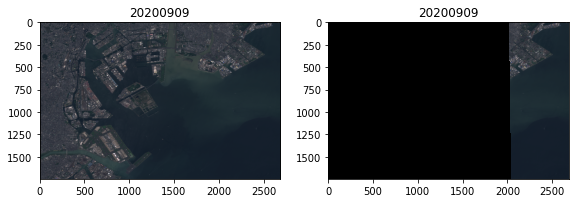

In [23]:
# 時系列で可視化
s2_path = '/content/drive/My Drive/' + dir_name_s2 + '/'
files =os.listdir(s2_path)
files.sort()

plt.figure(figsize=(25, 25))
j=0

v = len(files)//5 +1 
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s2_path + files[i]) as src:
      arr = src.read()
  j+=1# 画像のプロット位置をシフトさせ配置
  plt.subplot(v,5,j)
  arrayImg = np.asarray(arr).transpose(1,2,0).astype(np.float32)*2 #輝度を2倍に明るさを補正．
  plt.imshow(arrayImg)
  plt.title(files[i][0:8])# ファイル名から日付を取得
  #plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20200909


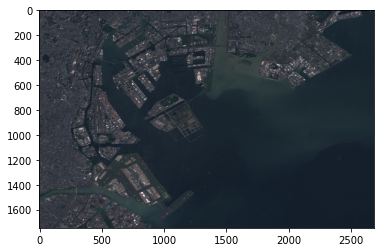

In [24]:
s2_path = '/content/drive/My Drive/' + dir_name_s2 + '/'
files =os.listdir(s2_path)
files.sort()

n = 0
# データの読み込み
with rasterio.open(s2_path  + files[n]) as src:
    arr = src.read()

#chanelとh，vの位置を変える
arrayImg = np.asarray(arr).transpose(1,2,0).astype(np.float32)*2

print(files[n][0:8])
# 可視化
plt.imshow(arrayImg)

(1746, 2685)
(1746, 2685)


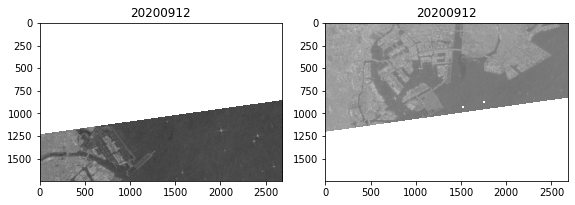

In [25]:
# 時系列で可視化
s1_path = '/content/drive/My Drive/' + dir_name_s1 + '/'
files =os.listdir(s1_path)
files.sort()

plt.figure(figsize=(20, 40))
j=0


v = len(files)//5 +1 
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s1_path + files[i]) as src:
      arr = src.read()
  print(arr[0].shape)
  j+=1# 画像のプロット位置をシフトさせ配置
  plt.subplot(v,5,j)
  plt.imshow(arr[0], cmap='gray')
  plt.title(files[i][33:41])# ファイル名から日付を取得
  date0 = files[i][33:41]
  plt.tight_layout()

  

20200912


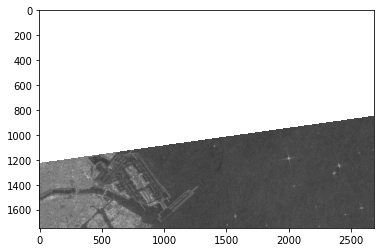

In [26]:
# データの読み込み
n = 0

with rasterio.open(s1_path + files[n]) as src:
    arr = src.read()

print(files[n][33:41])
# 可視化
plt.imshow(arr[0], cmap='gray')

type(arr[0])
image1 =np.zeros(arr[0].shape)

image_1 = np.nan_to_num(arr[0])

20200912


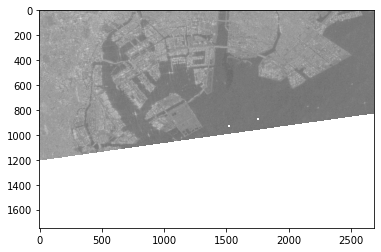

In [27]:
# データの読み込み
n = 1

with rasterio.open(s1_path + files[n]) as src:
    arr = src.read()

print(files[n][33:41])
# 可視化
plt.imshow(arr[0], cmap='gray')

type(arr[0])
image2 =np.zeros(arr[0].shape)

image_2 = np.nan_to_num(arr[0])

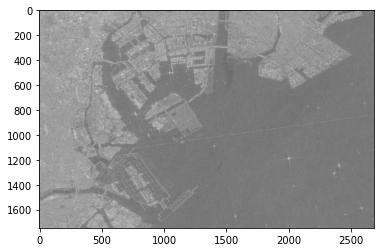

In [28]:
image_BG = image_1 + image_2
plt.imshow(image_BG, cmap='gray')

Lee filterによる平滑処理（スペックルノイズ除去）

In [29]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

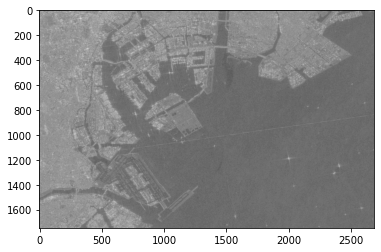

In [30]:
image_BG_lee = lee_filter(image_BG, 3)

plt.imshow(image_BG_lee,cmap='gray')

ベース画像の取得

In [31]:
#ベース画像の観測日を指定
date = datetime.date(2015, 9, 20)
print(date)

2015-09-20


In [32]:
dt = dt_now - date

if dt.days < 6:
  dt_nd = datetime.timedelta(days=12)
  dt_pd = datetime.timedelta(days=0)
else:
  dt_nd = datetime.timedelta(days=6)
  dt_pd = datetime.timedelta(days=6)

In [33]:
# 　観測期間

from_date= date - dt_nd
to_date= date + dt_pd

from_date = from_date.strftime('%Y-%m-%d')
to_date = to_date.strftime('%Y-%m-%d')


# 保存するフォルダ名
dir_name_s1 = 'GEE_Sentinel1_R_' + object_name
dir_name_s2 = 'GEE_Sentinel2_R_' + object_name

In [34]:
def ImageExport(image,description,folder,region,scale):
    task = ee.batch.Export.image.toDrive(image=image,description=description,folder=folder,region=region,scale=scale)
    task.start()

Sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(region).filterDate(parse(from_date),parse(to_date)).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select(['VV'])
#Sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(region).filterDate(parse(from_date),parse(to_date)).select(['VV'])

imageList_s1 = Sentinel1.toList(300)

In [35]:
for i in range(imageList_s1.size().getInfo()):
    image = ee.Image(imageList_s1.get(i))
    ImageExport(image.reproject(crs='EPSG:4326',scale=10),image.get('system:index').getInfo(),dir_name_s1,region['coordinates'][0],10)

(1746, 2685)


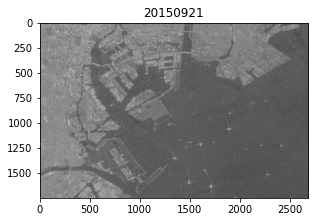

In [36]:
# 時系列で可視化
s1_path = '/content/drive/My Drive/' + dir_name_s1 + '/'
files =os.listdir(s1_path)
files.sort()

plt.figure(figsize=(20, 40))
j=0


v = len(files)//5 +1 
for i in range(len(files)):
  # 画像を1シーンずつ取得して可視化
  with rasterio.open(s1_path + files[i]) as src:
      arr = src.read()
  print(arr[0].shape)
  #print(image)
  j+=1# 画像のプロット位置をシフトさせ配
  plt.subplot(v,5,j)
  #image =  arr[0].fillna(0)
  plt.imshow(arr[0], cmap='gray')
  plt.title(files[i][33:41])# ファイル名から日付を取得
  date1 = files[i][33:41]
  plt.tight_layout()

20150921


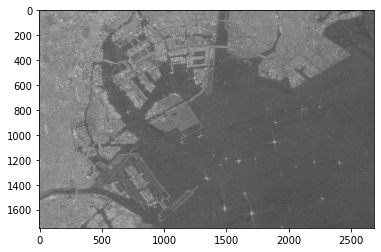

In [37]:
# データの読み込み
n = 0

with rasterio.open(s1_path + files[n]) as src:
    arr = src.read()

print(files[n][33:41])
# 可視化
plt.imshow(arr[0], cmap='gray')

type(arr[0])
image1 =np.zeros(arr[0].shape)

image_1 = np.nan_to_num(arr[0])

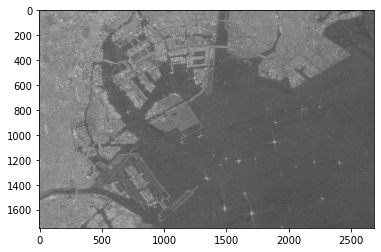

In [38]:
image_R = image_1 
plt.imshow(image_R, cmap='gray')

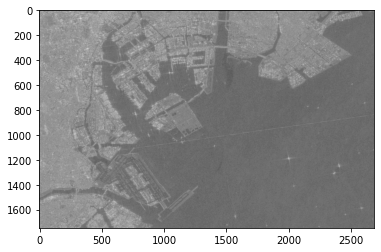

In [39]:
image_R_lee = lee_filter(image_BG, 3)

plt.imshow(image_R_lee,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1746, 2685, 3)


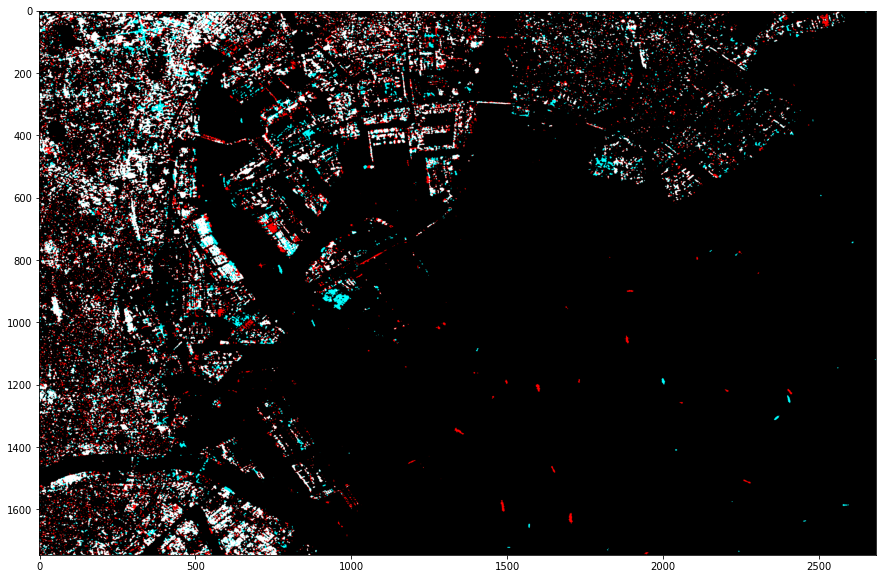

40.942115669096395


In [40]:
#RGB合成
RGB = np.dstack((image_R, np.dstack((image_BG_lee, image_BG_lee))))

print(RGB.shape)
plt.figure(figsize=(15, 20))
plt.imshow(RGB)
plt.show()

print(RGB.max())

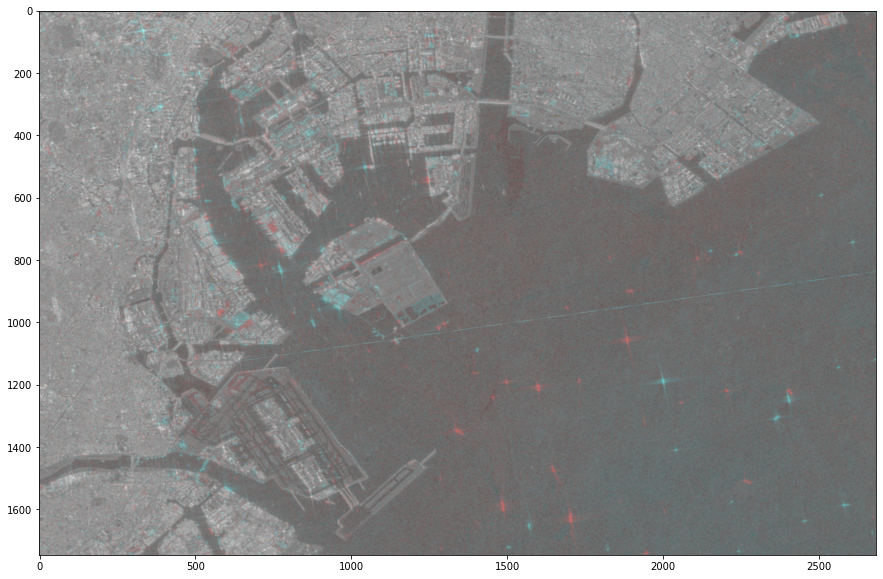

In [56]:
import cv2
from PIL import Image, ImageDraw, ImageFont

img_bgr = np.dstack((image_R, np.dstack((image_BG_lee, image_BG_lee))))

new_arr = ((img_bgr - img_bgr.min()) * (1/(img_bgr.max() - img_bgr.min()) * 255)).astype('uint8')


im_rgb = cv2.cvtColor(new_arr, cv2.COLOR_BGR2RGB)
cv2.imwrite(str(object_name) +'.jpg', im_rgb )

img = Image.open(str(object_name) +'.jpg')

plt.figure(figsize=(15, 20))

plt.imshow(img)
plt.show()

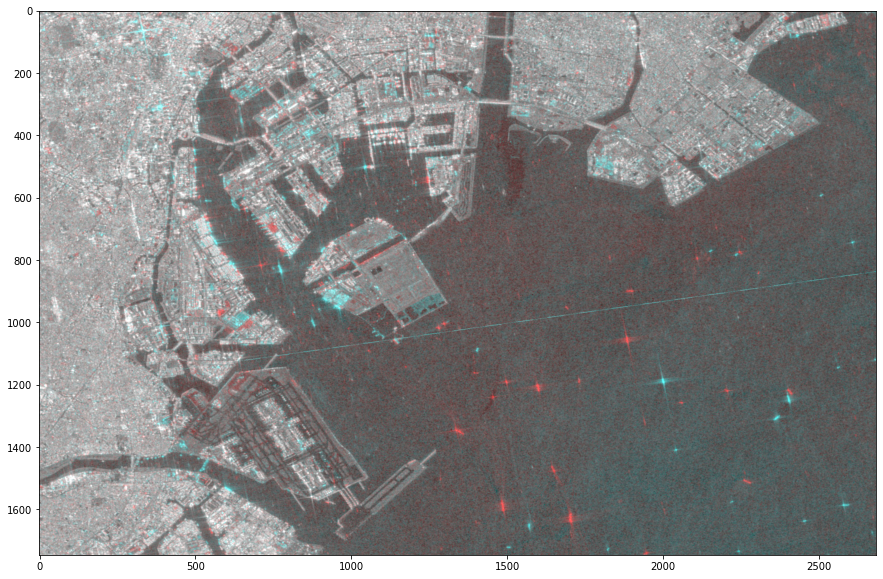

In [57]:
import PIL.Image
from PIL import ImageEnhance

IMAGE_PATH = str(object_name) +'.jpg'
CONTRAST = 2.0

img = PIL.Image.open(IMAGE_PATH)

# コントラストを変える
contrast_converter = ImageEnhance.Contrast(img)
contrast_img = contrast_converter.enhance(CONTRAST)

#　画像を保存
contrast_img.save(str(object_name) +'.jpg')

plt.figure(figsize=(15, 20))

plt.imshow(contrast_img)
plt.show()

RGB合成画像に取得日やクレジットを載せる．

In [43]:
#フォントファイルのダウンロードと設定

!wget https://osdn.net/dl/mplus-fonts/mplus-TESTFLIGHT-063a.tar.xz

!xz -dc mplus-TESTFLIGHT-*.tar.xz | tar xf -

fontfile = "./mplus-TESTFLIGHT-063a/mplus-1c-bold.ttf"

--2020-09-22 00:30:28--  https://osdn.net/dl/mplus-fonts/mplus-TESTFLIGHT-063a.tar.xz
Resolving osdn.net (osdn.net)... 202.221.179.17
Connecting to osdn.net (osdn.net)|202.221.179.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://osdn.net/projects/mplus-fonts/downloads/62344/mplus-TESTFLIGHT-063a.tar.xz/ [following]
--2020-09-22 00:30:28--  https://osdn.net/projects/mplus-fonts/downloads/62344/mplus-TESTFLIGHT-063a.tar.xz/
Reusing existing connection to osdn.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://osdn.net/frs/redir.php?m=constant&f=mplus-fonts%2F62344%2Fmplus-TESTFLIGHT-063a.tar.xz [following]
--2020-09-22 00:30:28--  https://osdn.net/frs/redir.php?m=constant&f=mplus-fonts%2F62344%2Fmplus-TESTFLIGHT-063a.tar.xz
Reusing existing connection to osdn.net:443.
HTTP request sent, awaiting response... 302 Found
Location: https://osdn.mirror.constant.com//mplus-fonts/62344/mplus-TESTFLIGHT-063a.tar.xz [following]
--2

Google Earth等で閲覧するためのkmzファイルを作成する．

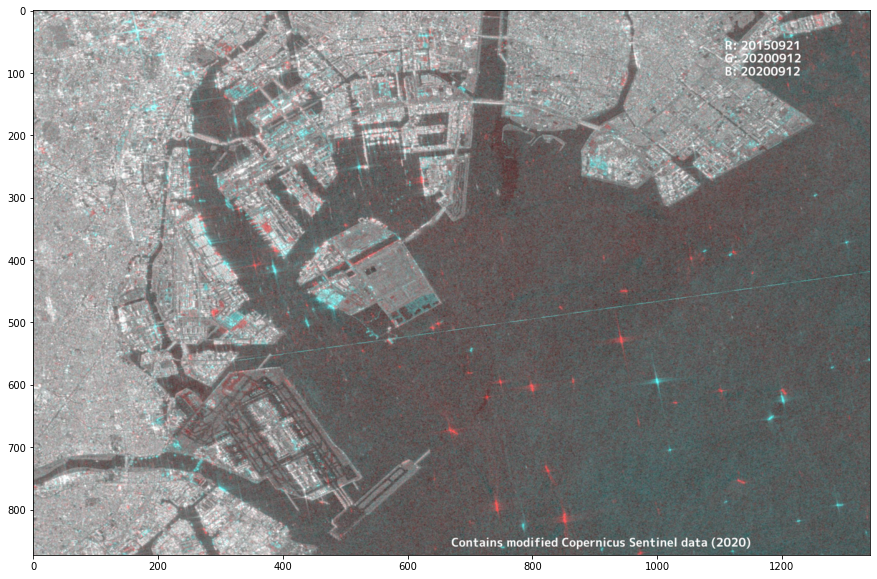

In [58]:
img = Image.open(str(object_name) +'.jpg')

img = img.convert('RGB')


x = int(img.size[0]/1.21) #日付の記載位置の設定
y = int(img.size[1]/20) #日付の記載位置の設定
fs = int(img.size[0]/70) #日付のフォントサイズの設定

obj_draw = ImageDraw.Draw(img)
obj_font = ImageFont.truetype(fontfile, fs)
obj_draw.text((x, y), 'R: '+str(date1), fill=(255, 255, 255), font=obj_font)
obj_draw.text((x, y+1.1*fs), 'G: '+str(date0), fill=(255, 255, 255), font=obj_font)
obj_draw.text((x, y+2.2*fs), 'B: '+str(date0), fill=(255, 255, 255), font=obj_font)
obj_draw.text((img.size[0]/2.0, img.size[1]-y*0.1 - img.size[1]/30 ), 'Contains modified Copernicus Sentinel data (2020)', fill=(255, 255, 255), font=obj_font)

img = img.resize((int(img.size[0] / 2) , int(img.size[1] / 2)))

#img = img.convert('L')


img.save(str(object_name) +'.jpg')

plt.figure(figsize=(15, 20))

plt.imshow(img)
plt.show()

In [44]:
!pip install simplekml

import simplekml
import zipfile

     |████████████████████████████████| 71kB 2.1MB/s eta 0:00:011


In [50]:
area = pd.DataFrame(AREA,
                  columns=['longtitude', 'latitude'])

In [51]:
north = area["latitude"].max()
south = area["latitude"].min()
east = area["longtitude"].max()
west = area["longtitude"].min()

In [52]:
#地理情報をkmlで出力．
kml = simplekml.Kml()
ground = kml.newgroundoverlay(name=str(object_name))
ground.icon.href = str(object_name) +'.jpg'
ground.latlonbox.north = north
ground.latlonbox.south = south
ground.latlonbox.east = east
ground.latlonbox.west = west
ground.latlonbox.rotation = 0
kml.save(str(object_name)+".kml")

In [53]:
#地理情報と画像とをあわせたkmzを出力．
with zipfile.ZipFile(str(object_name)+'.kmz', "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write(str(object_name)+".kml", arcname=str(object_name)+".kml")
    zf.write(str(object_name) +'.jpg', arcname=str(object_name) +'.jpg')